# A Raster Union and More Example

**Goal**: Plot all raster tiles within a radius of a site. 
**Bonus**: Plot all pit locations that fall in the same radius AND dem contours

**Approach**: 

1. Get site location geometry
2. Build a polygon of a circle of X meters radius centered on our pit
3. Grab all raster tiles that intersect our circle, and union them as a tiff. 
4. Build a geopandas dataframe with the pits in the circle. 
5. Plot it!

## Process
### Step 1. Get our desired pit location from the SiteData table

In [2]:
from snowexsql.db import get_db
from snowexsql.data import ImageData, SiteData
from rasterio.plot import show
from sqlalchemy.sql import func
import geoalchemy2.functions as gfunc
from geoalchemy2.types import Raster
from geoalchemy2.shape import to_shape
import geopandas as gpd
from snowexsql.conversions import raster_to_rasterio
from snowexsql.conversions import points_to_geopandas, query_to_geopandas
import matplotlib.pyplot as plt
import numpy as np

# Pit Site Identifier of interest
site_id = '5N19'

# Distance around the pit to collect data in meters
buffer_dist = 400

# Connect to the database we made.
db_name = 'db.snowexdata.org/snowex'
engine, session = get_db(db_name, credentials='./credentials.json')

datasets = []

# Grab our sites details by site id
q = session.query(SiteData).filter(SiteData.site_id==site_id)
sites = q.all()

# Grab the pit location from a single layer
p = sites[0].geom

# Convert the point to a pyshapely
pit = to_shape(p)

# Convert it to a geopandas dataframe for easy plotting 
df_pit = gpd.GeoSeries(pit)

### Step 2. Create a circle with radius of 400m centered on our pit

In [3]:
# Create a polygon buffered by our distance centered on the pit
q = session.query(gfunc.ST_Buffer(p, buffer_dist))
buffered_pit = q.all()[0][0]

# Convert to a shapely shapefile object 
circle = to_shape(buffered_pit)

# Convert to a geopandas dataframe
df_circle = gpd.GeoSeries(circle)

### Step 3. Union all Bare Earth DEM tiles touching our buffer circle

In [5]:
# Grab the rasters, union them and convert them as tiff when done
q = session.query(func.ST_AsTiff(func.ST_Union(ImageData.raster, type_=Raster)))

# Only grab rasters that are the bare earth DEM from USGS
q = q.filter(ImageData.type == 'DEM').filter(ImageData.surveyors=='USGS')

# And grab rasters touching the circle
q = q.filter(gfunc.ST_Intersects(ImageData.raster, buffered_pit))

# Execute the query
rasters = q.all()

# Get the rasterio object of the raster
dataset = raster_to_rasterio(session, rasters)[0]


### Step 4. Grab all site locations in the circle

In [6]:
# Form a query for retrieving the sites that are within the circle
q = session.query(SiteData.geom).filter(gfunc.ST_Within(SiteData.geom, buffered_pit))

# Create a geopandas dataframe of SiteData geometry in the circle
nearby_pits = query_to_geopandas(q, engine)

### Step 5. Plot the dem, with the pits overlaid. 

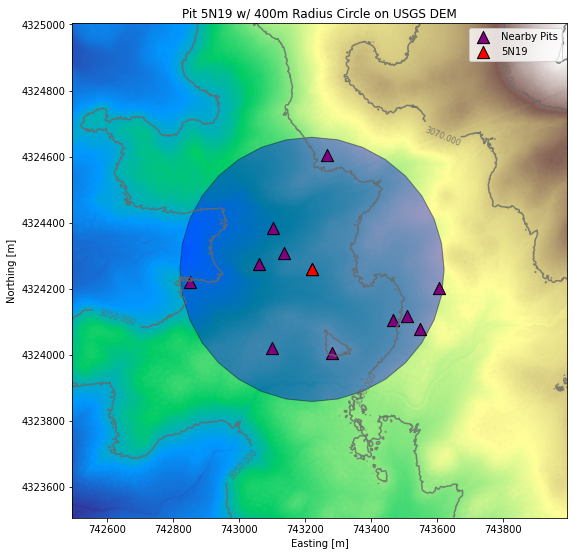

In [8]:
# Create a single plot to add everything to
fig, ax = plt.subplots(figsize=(8,8))

# Plot the DEM 
img = show(dataset.read(1), ax=ax, transform=dataset.transform, cmap='terrain')

# Plot the contours of the DEM (Just for kicks!) at 10m intervals
show(dataset.read(1), contour=True, levels=[s for s in np.arange(3000, 4000, 10)], colors='dimgray', ax=ax, transform=dataset.transform)

# Plot the circle as blue with slight transparency
df_circle.plot(ax=ax, color='b', alpha=0.4, edgecolor='black')

# Plot the nearby pits as purple triangles
nearby_pits.plot(ax=ax, color='purple', marker='^', label='Nearby Pits',  edgecolor='black', markersize=150)

# Plot pit as a red triangle
df_pit.plot(ax=ax, color='r', marker='^', label=site_id,  edgecolor='black', markersize=150)

# Don't use scientific notation on the axis ticks
ax.ticklabel_format(style='plain', useOffset=False)

# Add x/y labels, a title, a legend and avoid overlapping labels
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_title('Pit {} w/ {}m Radius Circle on USGS DEM'.format(site_id, buffer_dist))
ax.legend()
plt.tight_layout()

In [9]:
# Close the dataset and end the database session
dataset.close()
session.close()